In [1]:
import numpy as np
import pandas as pd
import re
import os
from os import path
import sys
from metrics import get_metrics, aggregate_res
from datetime import date

In [2]:
result_tissue = 'BMMC'

In [3]:
dic = {'num_cells': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 
                     '1', '3', '5', '10', '15', '20'],
       'num_RNA_cells': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 
                         '1', '3', '5', '10', '15', '20'],
       'num_multiome_cells': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
                              '1', '3', '5', '10', '15'],
       'per_mislabel': ['1', '5', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],
       'per_downsample': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
       'per_RNA_downsample': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
       'per_ATAC_downsample': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
       'per_multiome_downsample': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
       'rm_RNA_ct': ['2', '4', '6', '8', '10'],
       'rm_multiome_ct': ['2', '4', '6', '8', '10']}

In [4]:
dic = {'num_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'num_RNA_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'num_multiome_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'per_mislabel': ['10', '30', '50', '70', '90'],
       'per_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_RNA_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_ATAC_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_multiome_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'rm_RNA_ct': ['2', '6', '10'],
       'rm_multiome_ct': ['2', '6', '10']}

In [5]:
# dic for result to data subfolder mapping
dic_map_atac = {'kidney': 'kidney/ATAC',
               'lung_droplet': 'lung/sci-atac',
               'lung_facs': 'lung/sci-atac',
               'brain_snare': 'brain/sci-atac',
               'brain_share': 'brain/sci-atac',
               'BMMC_processed_s3d7': 'BMMC_processed_s3d7/ATAC',
               'PBMC': 'PBMC/ATAC', 
               'BMMC': 'BMMC/ATAC'
}
dic_map_rna = {'kidney': 'kidney/RNA',
               'lung_droplet': 'lung/droplet',
               'lung_facs': 'lung/FACS',
               'brain_snare': 'brain/FACS',
               'brain_share': 'brain/FACS',
               'BMMC_processed_s3d7': 'BMMC_processed_s3d7/RNA',
               'PBMC': 'PBMC/RNA',
               'BMMC': 'BMMC/RNA'
}
data_tissue_atac = dic_map_atac[result_tissue]
data_tissue_rna = dic_map_rna[result_tissue]

In [6]:
# paths
data_path = '/gpfs/gibbs/pi/zhao/xs272/Multiomics/sc_benchmark/data/%s' % data_tissue_atac
rna_path = '/gpfs/gibbs/pi/zhao/xs272/Multiomics/sc_benchmark/data/%s' % data_tissue_rna
result_path = '/gpfs/gibbs/pi/zhao/xs272/Multiomics/sc_benchmark/results/%s' % result_tissue

In [7]:
# dic for sim matrix for each data
dic_sim = {'kidney': '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseKidney/sim_kidney.csv',
           'brain': '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas/sim_brain.csv',
           'lung': '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas/sim_lung.csv',
           'BMMC': '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/BMMC/sim_BMMC.csv',
           'PBMC': '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/PBMC/sim_PBMC.csv',
          }

In [8]:
import warnings
warnings.warn("deprecated", DeprecationWarning)

/tmp/ipykernel_15043/1829131520.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


In [105]:
for xp in dic.keys():
    print('\n')
    print(xp)
    if xp == 'num_cells':
        continue
    # loop through each method
    if result_tissue == 'lung':
        methods = ['conos', 'conos_pagoda', 'seurat3', 'scGCN', 'scJoint', 'knn', 'random', 'ensemble']
    else:
        methods = ['conos', 'conos_pagoda', 'bridge', 'seurat3', 'scGCN', 'scJoint', 'knn', 'random', 'ensemble']
    # methods = ['bridge', 'seurat3', 'scGCN', 'scJoint']
    re = []

    for method in methods:
        for p in dic[xp]:
            for seed in range(20):
                if xp in ['per_mislabel', 'per_downsample', 'per_RNA_downsample', 'per_ATAC_downsample', 'per_multiome_downsample']:
                    prefix = 'p'
                else:
                    prefix = 'k'
                # load prob matrix
                try:
                    prob = pd.read_csv(path.join(result_path, xp, '%s%s/seed%s' % (prefix, p, seed), '%s/prob.csv' % method), index_col=0)
                except:
                    print('File not available for %s under %s with parameter %s and seed %s' % (method, xp, p, seed))
                    continue
                ## load true labels
                cells = np.loadtxt(path.join(data_path, 'cells.txt'), dtype=object, delimiter='SPACEISPARTOFTHENAME')
                true_label = np.loadtxt(path.join(data_path, 'annotations.txt'), dtype=object, delimiter='SPACESHOULDB')
                true_label = pd.DataFrame(true_label, index = cells, columns = ['annotation'])
                ## load sim matrix
                sim = pd.read_csv(dic_sim[result_tissue.split('_')[0]], index_col=0)
                ## prepare input to aggregate_res
                if xp == 'per_mislabel':
                    RNA_path = '%s/annotations_mis_percent_%s.txt' % (rna_path, p)
                else:
                    RNA_path = rna_path
                param = [prob, true_label, sim, p, seed, method, RNA_path]
                re.append(param)
                
    print(len(re))
    # run evaluation
    if xp in ['rm_RNA_ct']:
        compare_res = aggregate_res_xp(re, atac_unique=True)
    else:
        compare_res = aggregate_res_xp(re, atac_unique=False)
    compare_res['xp'] = xp
    print(compare_res.shape)
    compare_res.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_%s.csv' % (xp, date.today()))



num_cells


num_RNA_cells
1080


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/s

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

(1080, 9)


num_multiome_cells
File not available for conos under num_multiome_cells with parameter 0.2 and seed 0
File not available for conos under num_multiome_cells with parameter 0.2 and seed 1
File not available for conos under num_multiome_cells with parameter 0.2 and seed 2
File not available for conos under num_multiome_cells with parameter 0.2 and seed 3
File not available for conos under num_multiome_cells with parameter 0.2 and seed 4
File not available for conos under num_multiome_cells with parameter 0.2 and seed 5
File not available for conos under num_multiome_cells with parameter 0.2 and seed 6
File not available for conos under num_multiome_cells with parameter 0.2 and seed 7
File not available for conos under num_multiome_cells with parameter 0.2 and seed 8
File not available for conos under num_multiome_cells with parameter 0.2 and seed 9
File not available for conos under num_multiome_cells with parameter 0.2 and seed 10
File not available for conos under num_multi

File not available for conos under num_multiome_cells with parameter 10 and seed 13
File not available for conos under num_multiome_cells with parameter 10 and seed 14
File not available for conos under num_multiome_cells with parameter 10 and seed 15
File not available for conos under num_multiome_cells with parameter 10 and seed 16
File not available for conos under num_multiome_cells with parameter 10 and seed 17
File not available for conos under num_multiome_cells with parameter 10 and seed 18
File not available for conos under num_multiome_cells with parameter 10 and seed 19
File not available for conos_pagoda under num_multiome_cells with parameter 0.2 and seed 0
File not available for conos_pagoda under num_multiome_cells with parameter 0.2 and seed 1
File not available for conos_pagoda under num_multiome_cells with parameter 0.2 and seed 2
File not available for conos_pagoda under num_multiome_cells with parameter 0.2 and seed 3
File not available for conos_pagoda under num_mu

File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 0
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 1
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 2
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 3
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 4
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 5
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 6
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 7
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 8
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 9
File not available for seurat3 under num_multiome_cells with parameter 0.2 and seed 10
File not available for seurat3 under num_multiome_cel

File not available for scGCN under num_multiome_cells with parameter 3 and seed 0
File not available for scGCN under num_multiome_cells with parameter 3 and seed 1
File not available for scGCN under num_multiome_cells with parameter 3 and seed 2
File not available for scGCN under num_multiome_cells with parameter 3 and seed 3
File not available for scGCN under num_multiome_cells with parameter 3 and seed 4
File not available for scGCN under num_multiome_cells with parameter 3 and seed 5
File not available for scGCN under num_multiome_cells with parameter 3 and seed 6
File not available for scGCN under num_multiome_cells with parameter 3 and seed 7
File not available for scGCN under num_multiome_cells with parameter 3 and seed 8
File not available for scGCN under num_multiome_cells with parameter 3 and seed 9
File not available for scGCN under num_multiome_cells with parameter 3 and seed 10
File not available for scGCN under num_multiome_cells with parameter 3 and seed 11
File not avail

File not available for knn under num_multiome_cells with parameter 0.2 and seed 14
File not available for knn under num_multiome_cells with parameter 0.2 and seed 15
File not available for knn under num_multiome_cells with parameter 0.2 and seed 16
File not available for knn under num_multiome_cells with parameter 0.2 and seed 17
File not available for knn under num_multiome_cells with parameter 0.2 and seed 18
File not available for knn under num_multiome_cells with parameter 0.2 and seed 19
File not available for knn under num_multiome_cells with parameter 0.6 and seed 0
File not available for knn under num_multiome_cells with parameter 0.6 and seed 1
File not available for knn under num_multiome_cells with parameter 0.6 and seed 2
File not available for knn under num_multiome_cells with parameter 0.6 and seed 3
File not available for knn under num_multiome_cells with parameter 0.6 and seed 4
File not available for knn under num_multiome_cells with parameter 0.6 and seed 5
File not a

File not available for random under num_multiome_cells with parameter 5 and seed 7
File not available for random under num_multiome_cells with parameter 5 and seed 8
File not available for random under num_multiome_cells with parameter 5 and seed 9
File not available for random under num_multiome_cells with parameter 5 and seed 10
File not available for random under num_multiome_cells with parameter 5 and seed 11
File not available for random under num_multiome_cells with parameter 5 and seed 12
File not available for random under num_multiome_cells with parameter 5 and seed 13
File not available for random under num_multiome_cells with parameter 5 and seed 14
File not available for random under num_multiome_cells with parameter 5 and seed 15
File not available for random under num_multiome_cells with parameter 5 and seed 16
File not available for random under num_multiome_cells with parameter 5 and seed 17
File not available for random under num_multiome_cells with parameter 5 and see

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

(120, 9)


per_mislabel
900


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/s

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/s

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/s

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

(900, 9)


per_downsample
900


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

(900, 9)


per_RNA_downsample
900


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

(900, 9)


per_ATAC_downsample
900


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

(900, 9)


per_multiome_downsample
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 0
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 1
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 2
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 3
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 4
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 5
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 6
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 7
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 8
File not available for conos under per_multiome_downsample with parameter 0.1 and seed 9
File not available for conos under per_multiome_downsample with parameter 0

File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 3
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 4
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 5
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 6
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 7
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 8
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 9
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 10
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 11
File not available for conos_pagoda under per_multiome_downsample with parameter 0.9 and seed 12
File not available for conos_pagoda u

File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 12
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 13
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 14
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 15
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 16
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 17
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 18
File not available for scJoint under per_multiome_downsample with parameter 0.1 and seed 19
File not available for scJoint under per_multiome_downsample with parameter 0.3 and seed 0
File not available for scJoint under per_multiome_downsample with parameter 0.3 and seed 1
File not available for scJoint under per_multiome_downsample with parameter 0.3 an

File not available for random under per_multiome_downsample with parameter 0.3 and seed 0
File not available for random under per_multiome_downsample with parameter 0.3 and seed 1
File not available for random under per_multiome_downsample with parameter 0.3 and seed 2
File not available for random under per_multiome_downsample with parameter 0.3 and seed 3
File not available for random under per_multiome_downsample with parameter 0.3 and seed 4
File not available for random under per_multiome_downsample with parameter 0.3 and seed 5
File not available for random under per_multiome_downsample with parameter 0.3 and seed 6
File not available for random under per_multiome_downsample with parameter 0.3 and seed 7
File not available for random under per_multiome_downsample with parameter 0.3 and seed 8
File not available for random under per_multiome_downsample with parameter 0.3 and seed 9
File not available for random under per_multiome_downsample with parameter 0.3 and seed 10
File not 

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/met

(100, 9)


rm_RNA_ct
540


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: divide by zero encountered in log2
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy = np.nansum(-S*np.log2(S), axis=1).mean()/np.log2(S.shape[1])
/gpfs/gibbs/pi/zhao/yw5

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

(540, 13)


rm_multiome_ct
File not available for conos under rm_multiome_ct with parameter 2 and seed 0
File not available for conos under rm_multiome_ct with parameter 2 and seed 1
File not available for conos under rm_multiome_ct with parameter 2 and seed 2
File not available for conos under rm_multiome_ct with parameter 2 and seed 3
File not available for conos under rm_multiome_ct with parameter 2 and seed 4
File not available for conos under rm_multiome_ct with parameter 2 and seed 5
File not available for conos under rm_multiome_ct with parameter 2 and seed 6
File not available for conos under rm_multiome_ct with parameter 2 and seed 7
File not available for conos under rm_multiome_ct with parameter 2 and seed 8
File not available for conos under rm_multiome_ct with parameter 2 and seed 9
File not available for conos under rm_multiome_ct with parameter 2 and seed 10
File not available for conos under rm_multiome_ct with parameter 2 and seed 11
File not available for conos under 

File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 0
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 1
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 2
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 3
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 4
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 5
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 6
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 7
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 8
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 9
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 10
File not available for seurat3 under rm_multiome_ct with parameter 2 and seed 11
File not available for seurat3 under r

File not available for knn under rm_multiome_ct with parameter 2 and seed 16
File not available for knn under rm_multiome_ct with parameter 2 and seed 17
File not available for knn under rm_multiome_ct with parameter 2 and seed 18
File not available for knn under rm_multiome_ct with parameter 2 and seed 19
File not available for knn under rm_multiome_ct with parameter 6 and seed 0
File not available for knn under rm_multiome_ct with parameter 6 and seed 1
File not available for knn under rm_multiome_ct with parameter 6 and seed 2
File not available for knn under rm_multiome_ct with parameter 6 and seed 3
File not available for knn under rm_multiome_ct with parameter 6 and seed 4
File not available for knn under rm_multiome_ct with parameter 6 and seed 5
File not available for knn under rm_multiome_ct with parameter 6 and seed 6
File not available for knn under rm_multiome_ct with parameter 6 and seed 7
File not available for knn under rm_multiome_ct with parameter 6 and seed 8
File not

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-pack

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/skl

(60, 9)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualizations

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
sns.set(rc={'figure.figsize':(5,6)})

In [70]:
methods = ['conos', 'conos_pagoda', 'bridge', 'seurat3', 'scGCN', 'scJoint', 'knn', 'random', 'ensemble']

In [71]:
sns.set(font_scale = 1.3, style='white')

In [72]:
dic = {'overall_accuracy': 'Overall accuracy',
       'weighted_accuracy': 'Weighted accuracy',
       'f1 macro': 'F1 (macro)',
       'weighted_accuracy_for_unique_ct_in_atac': 'Weighted accuracy \n(unique cell types in ATAC)',
       'f1_for_unique_ct_in_atac': 'F1 of entropy and enrichment \n(unique cell types in ATAC)'}

In [73]:
title_dic = {'rm_RNA_ct': 'Number of removed cell types in RNA',
             'rm_multiome_ct': 'Number of removed cell types in multiome',
             'num_cells': 'Number of cells (k)',
             'num_RNA_cells': 'Number of RNA cells (k)',
             'num_multiome_cells': 'Number of multiome cells (k)',
             'per_mislabel':'Mislabel proportion',
             'per_downsample': 'Downsampling proportion',
             'per_RNA_downsample': 'Downsampling proportion of RNA cells',
             'per_ATAC_downsample': 'Downsampling proportion of ATAC cells',
             'per_multiome_downsample': 'Downsampling proportion of multiome cells'}

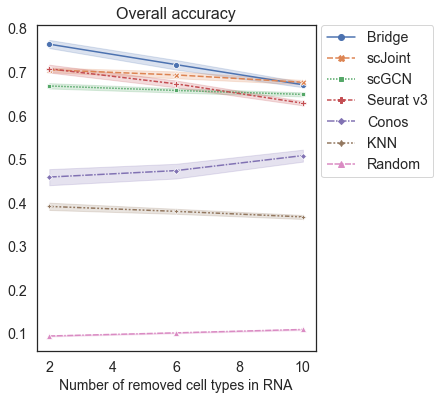

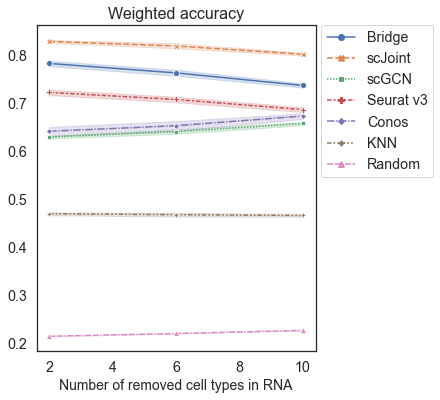

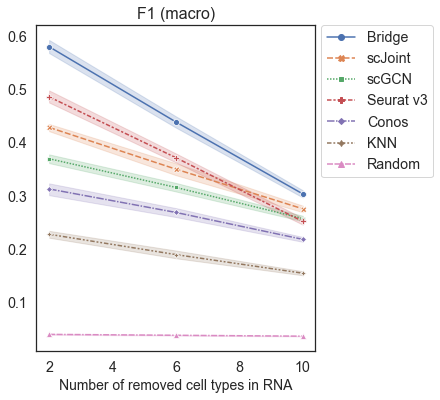

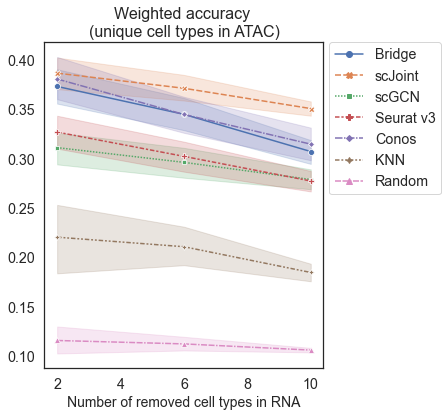

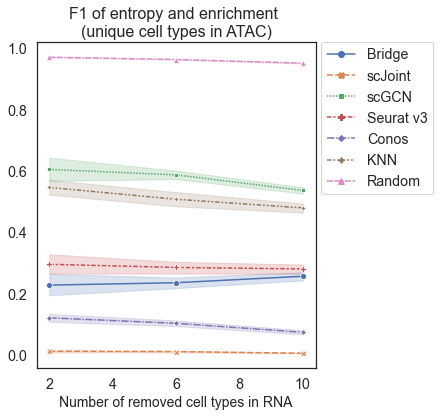

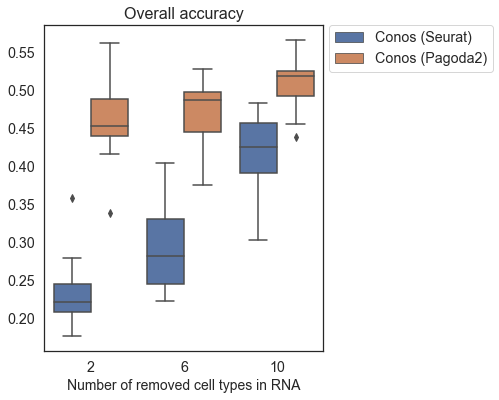

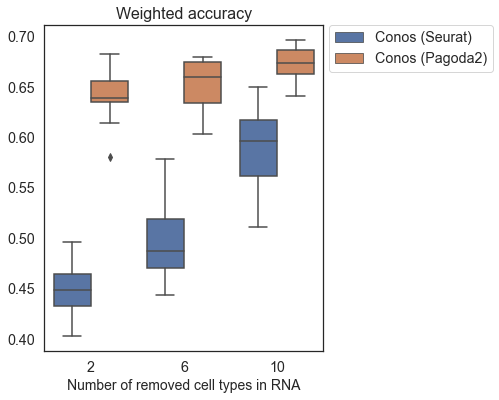

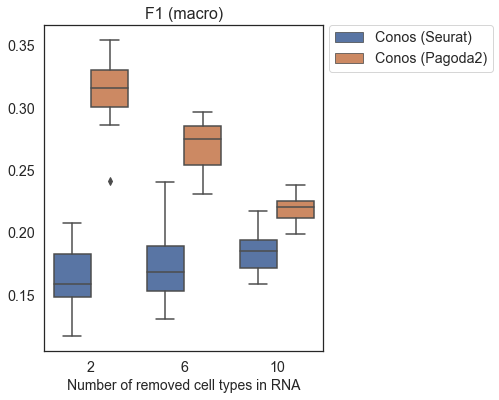

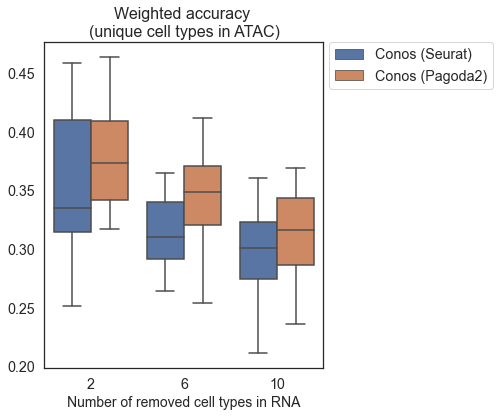

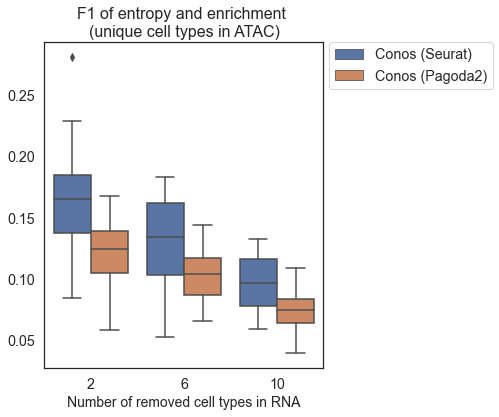

In [74]:
xp = 'rm_RNA_ct'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

In [77]:
dic = {'overall_accuracy': 'Overall accuracy',
       'weighted_accuracy': 'Weighted accuracy',
       'f1 macro': 'F1 (macro)'}

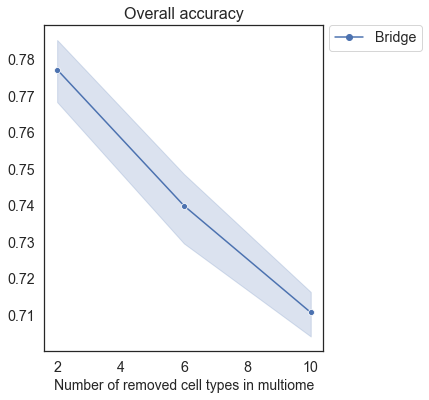

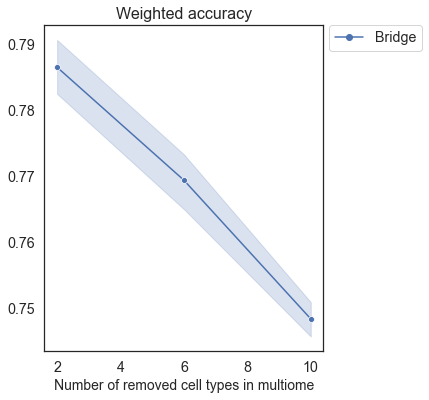

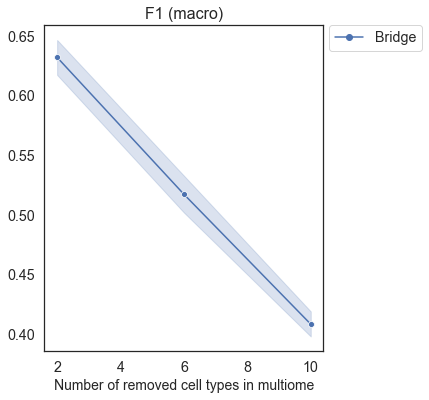

In [78]:
xp = 'rm_multiome_ct'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
for m in dic.keys():
    fig, ax = plt.subplots()
#     paper_rc = {'lines.linewidth': 1}
#     sns.set_context("paper", rc = paper_rc)
#     sns.pointplot(x='data', y=m, hue='method', data=df, ax=ax, capsize=.2, errorbar=("se", 1.96))
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df, ax=ax) 
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")

In [79]:
xp = 'rm_RNA_ct'
df1 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df1 = df1.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'rm_multiome_ct'
df2 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df2 = df2.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Cono', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

In [80]:
df_m = pd.concat([df1,df2])
df_m.index = pd.Index(np.arange(df_m.shape[0]))
df_m = df_m.replace({'rm_RNA_ct': 'Remove cell\n types in RNA', 'rm_multiome_ct': 'Remove cell\n types in multiome'})

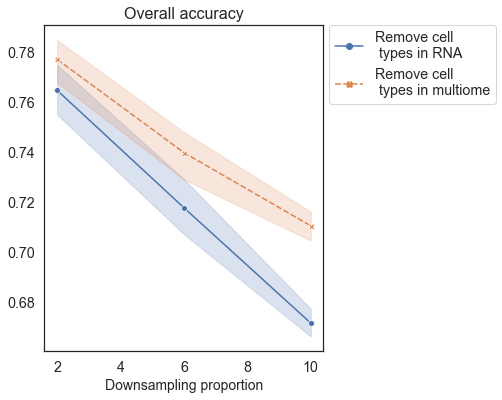

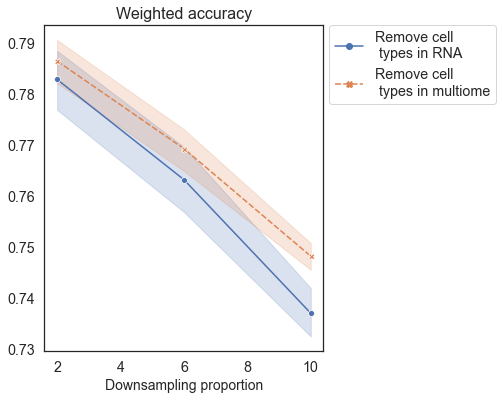

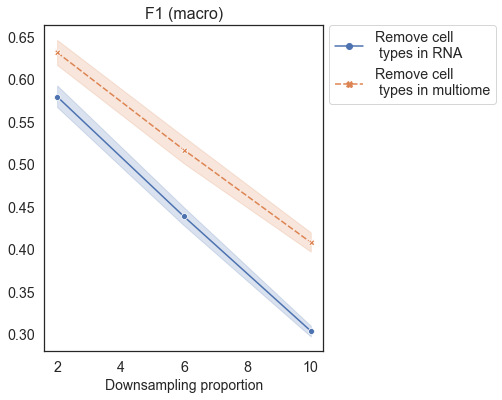

In [81]:
# methods = ['Bridge integration', 'scJoint', 'scGCN', 'Seurat3','Conos (Pagoda2)', 'KNN', 'Random']
for method in ['Bridge']:
    for m in dic.keys():
        fig, ax = plt.subplots()
    #     sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method=='Bridge integration'], ax=ax, err_style="bars", errorbar=("se", 1.96))
        sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method==method], ax=ax)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        ax.set_ylabel('')
        ax.set_xlabel('Downsampling proportion', fontsize=14)
        ax.set_title(dic[m], fontsize=16)
        plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_rm_ct_%s_%s.png' % (method, m), dpi=600, bbox_inches="tight")

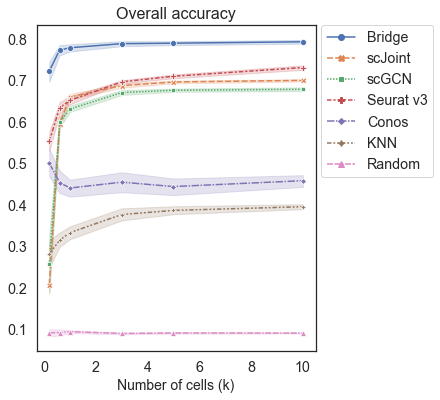

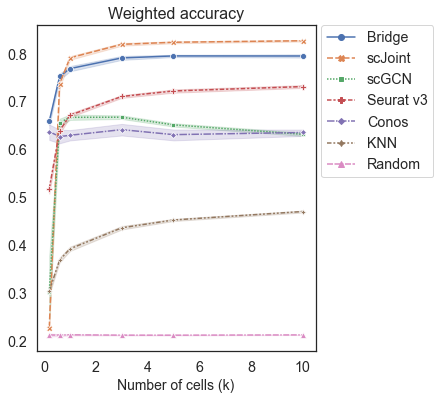

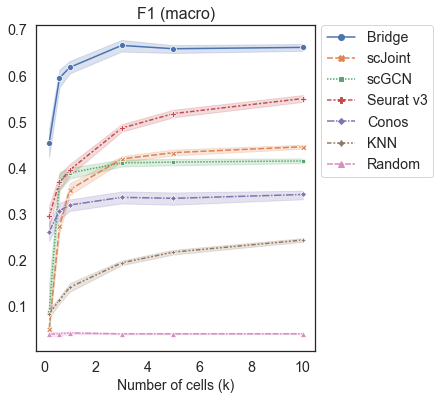

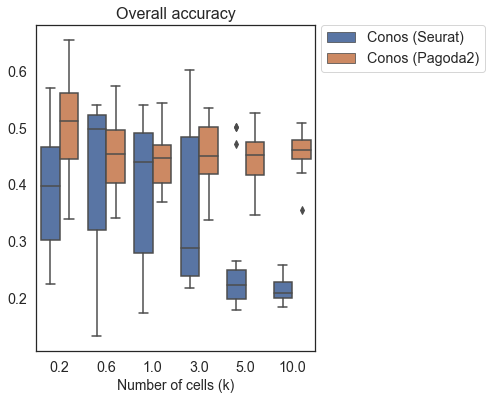

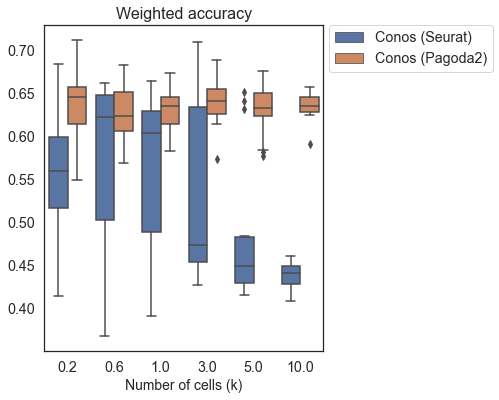

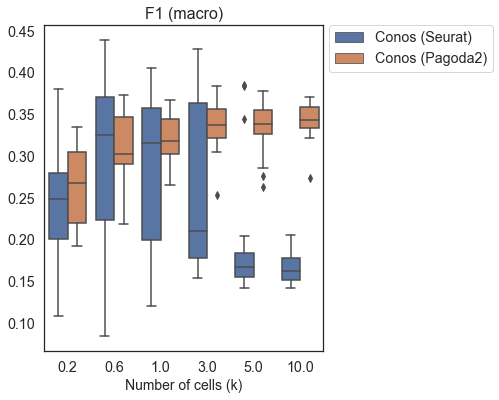

In [82]:
xp = 'num_cells'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df[df.data.isin([0.2,0.6,1,3,5,10])]
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3', 'Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

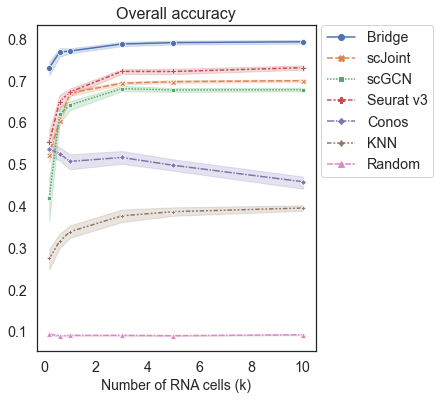

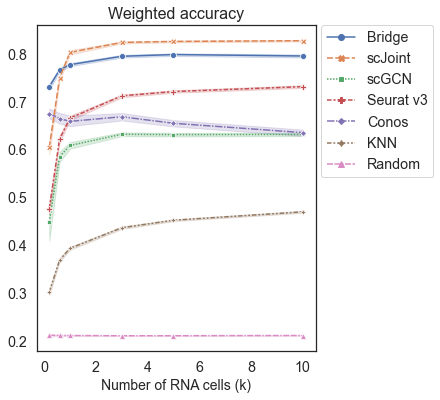

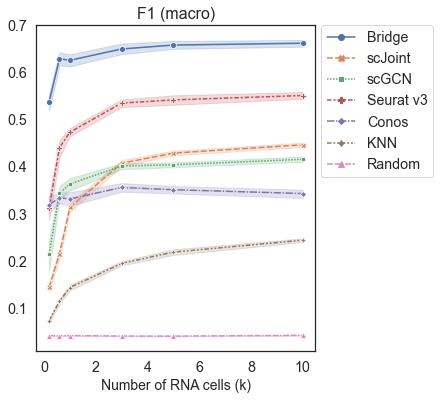

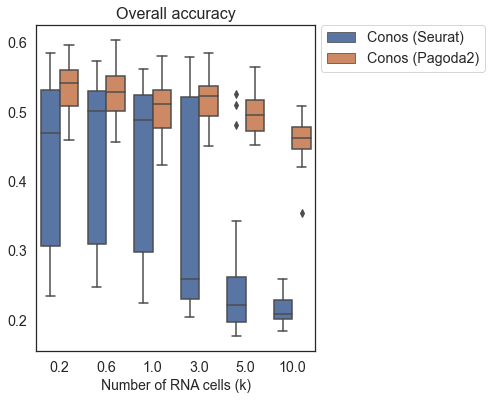

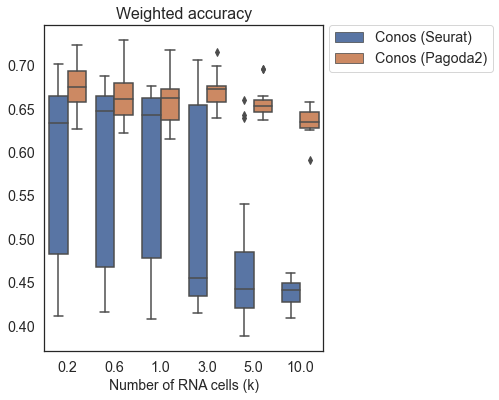

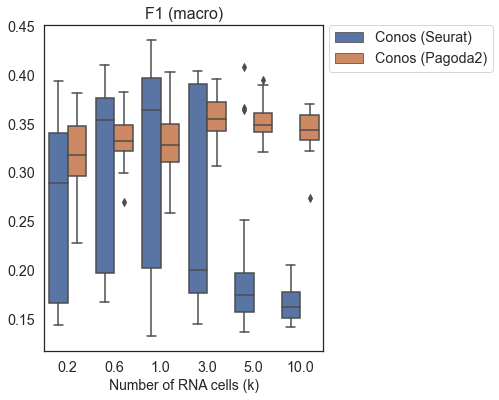

In [83]:
xp = 'num_RNA_cells'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df[df.data.isin([0.2,0.6,1,3,5,10])]
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

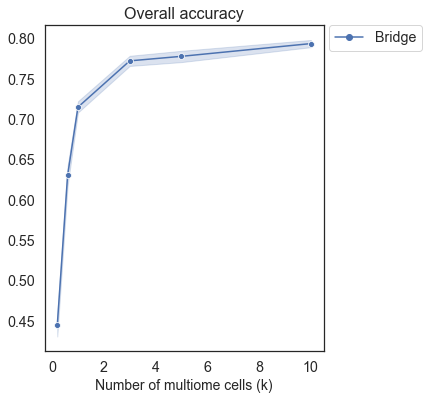

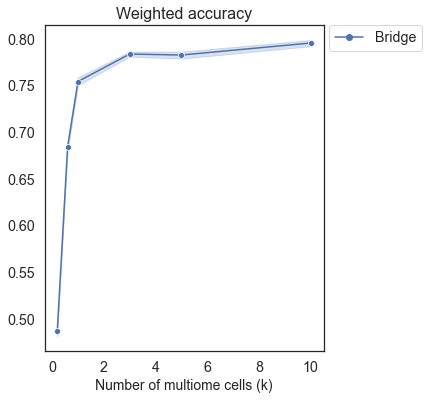

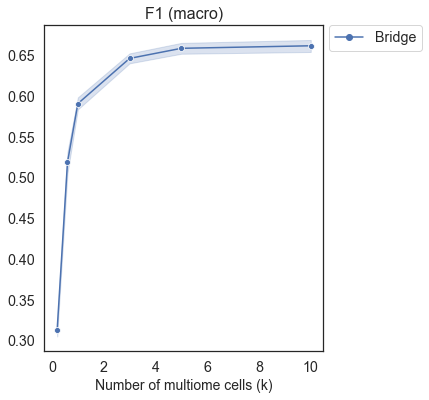

In [84]:
xp = 'num_multiome_cells'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df[df.data.isin([0.2,0.6,1,3,5,10])]
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")

In [85]:
# xp = 'num_cells'
# df1 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
# df1 = df1.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
#        'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'num_RNA_cells'
df2 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df2 = df2.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'num_multiome_cells'
df3 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df3 = df3.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

In [86]:
df_m = pd.concat([df2,df3])
df_m.index = pd.Index(np.arange(df_m.shape[0]))
df_m = df_m.replace({'num_RNA_cells': '#RNA cells', 'num_multiome_cells': '#multiome cells'})

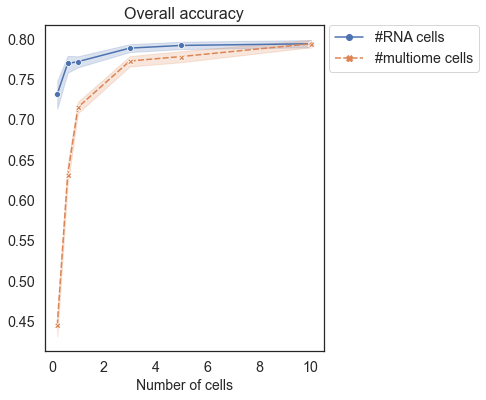

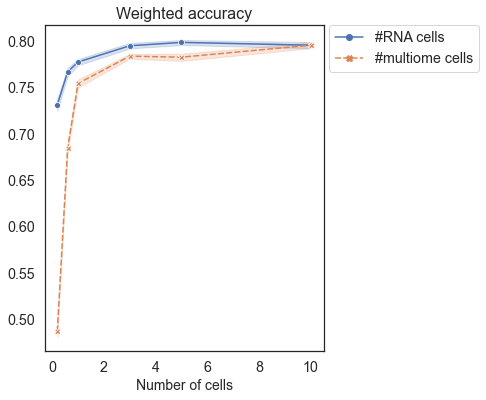

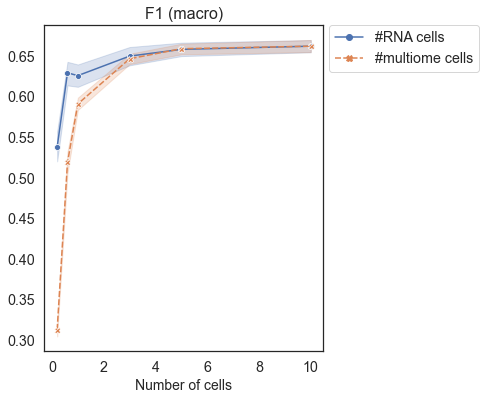

In [87]:
for method in ['Bridge']:
    for m in dic.keys():
        fig, ax = plt.subplots()
    #     sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method=='Bridge integration'], ax=ax, err_style="bars", errorbar=("se", 1.96))
        sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method==method], ax=ax)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        ax.set_ylabel('')
        ax.set_xlabel('Number of cells', fontsize=14)
        ax.set_title('%s' % (dic[m]), fontsize=16)
        plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_num_cells_%s_%s.png' % (method, m), dpi=600, bbox_inches="tight")

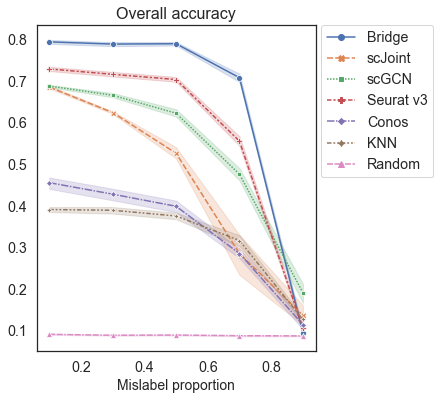

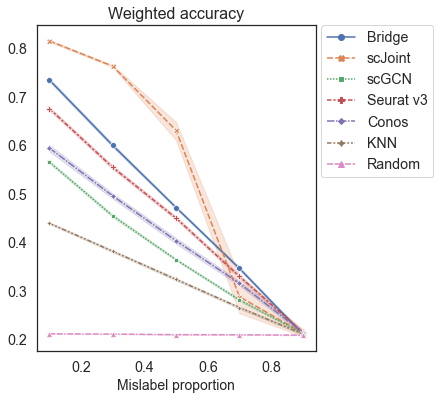

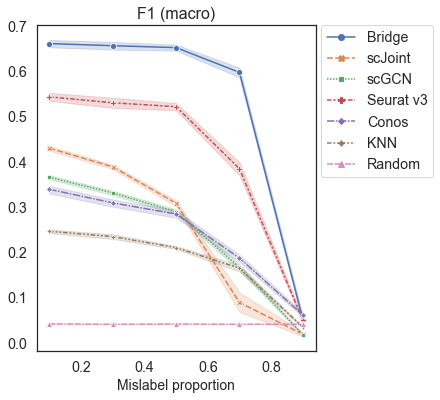

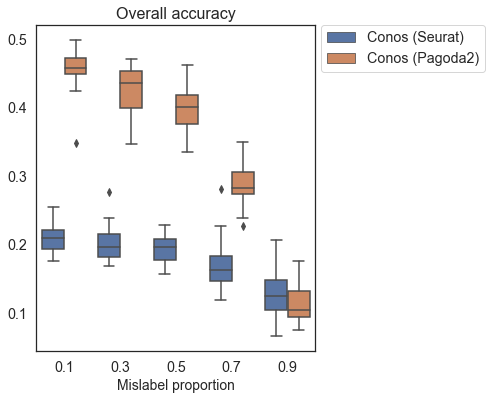

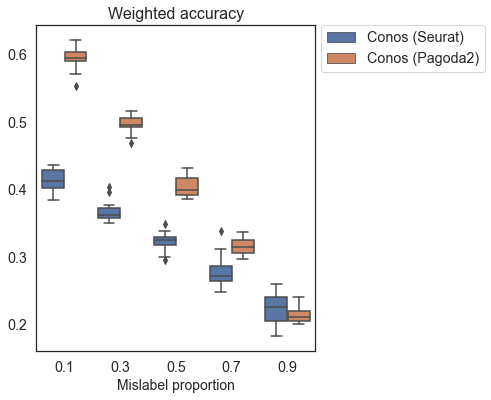

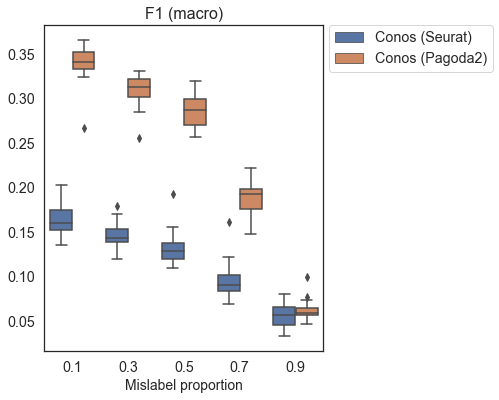

In [88]:
xp = 'per_mislabel'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df[df.data.isin(list(np.arange(10,100, step=10)))]
df.data = df.data/100
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

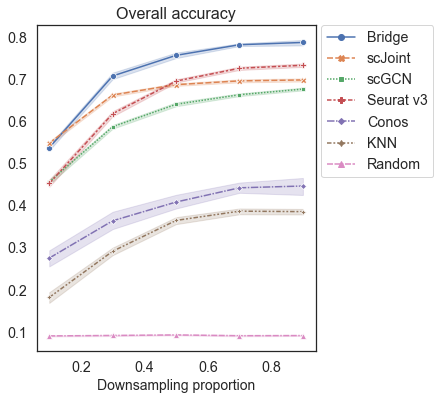

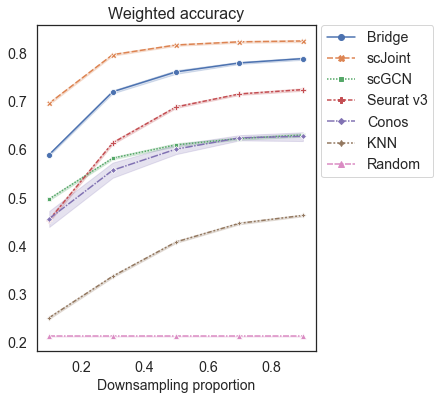

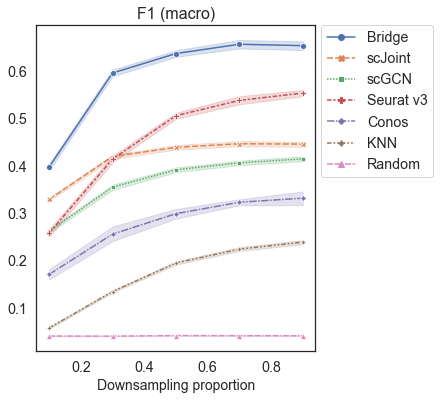

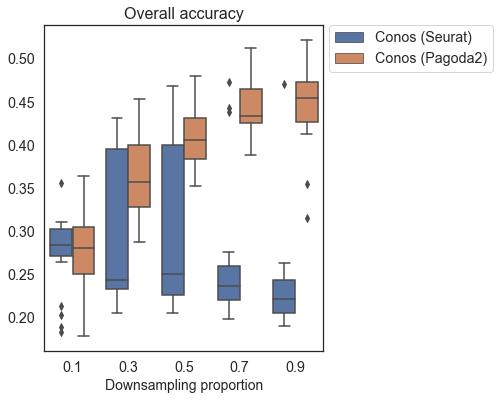

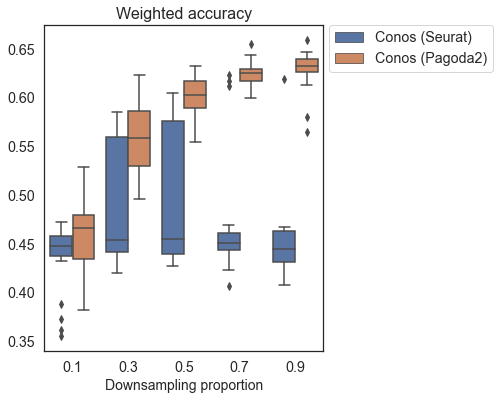

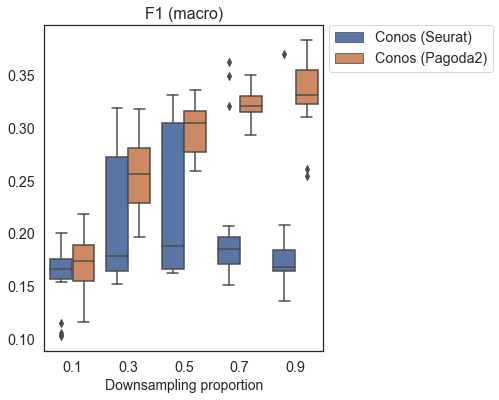

In [89]:
xp = 'per_downsample'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

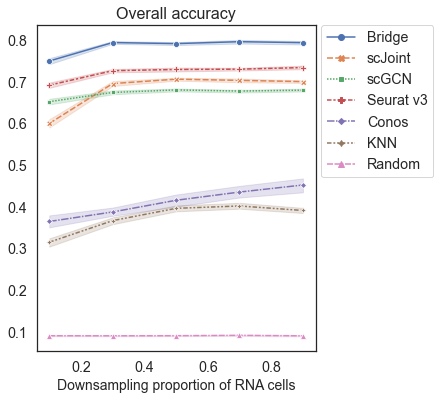

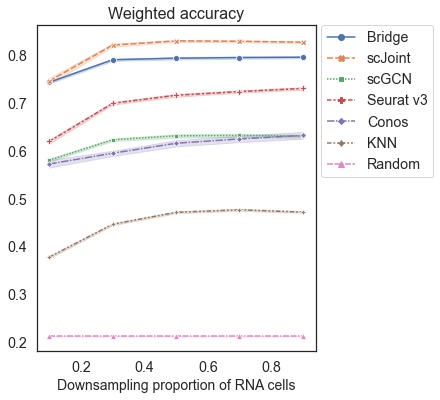

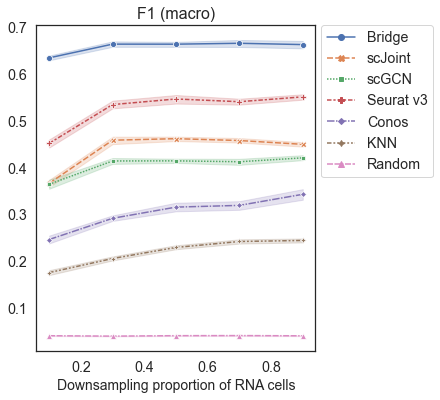

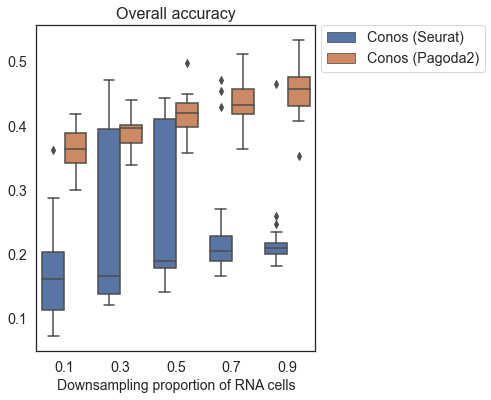

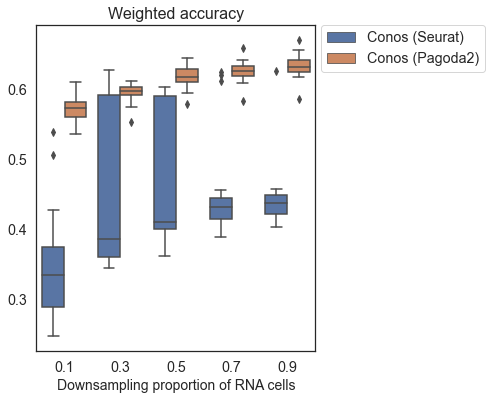

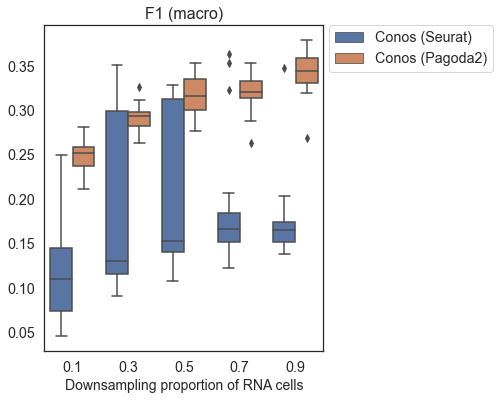

In [90]:
xp = 'per_RNA_downsample'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

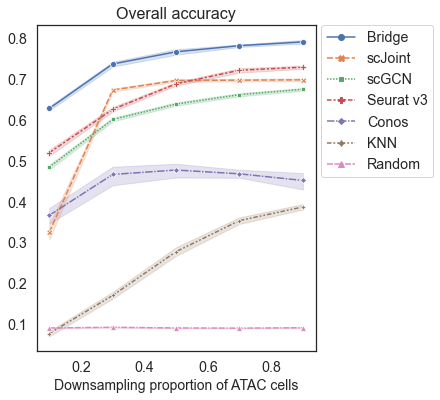

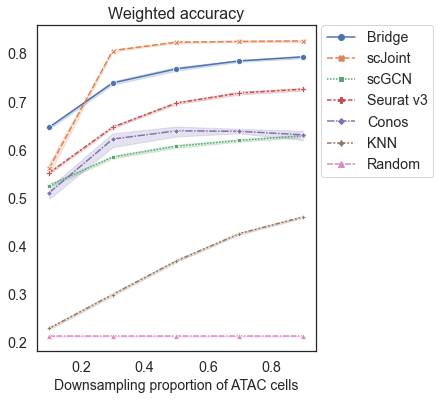

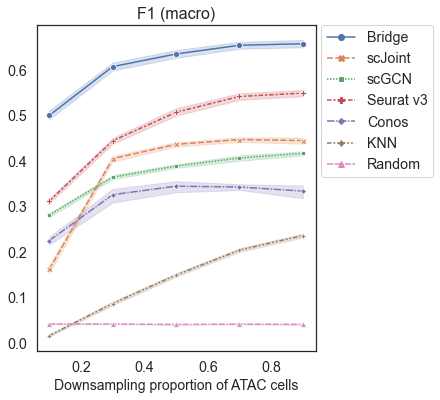

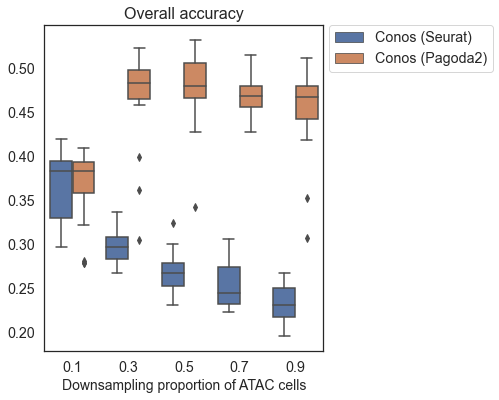

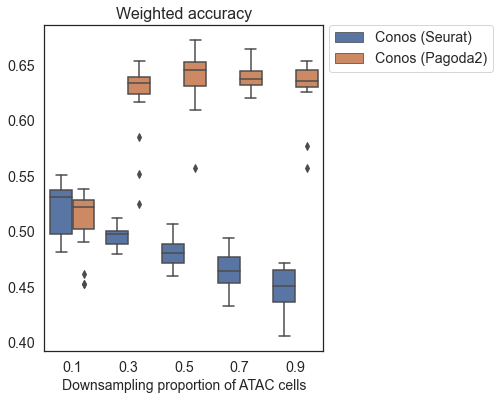

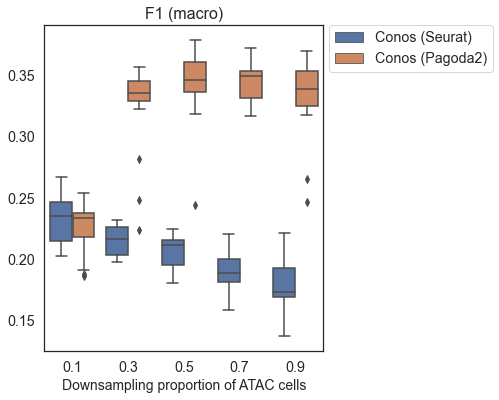

In [91]:
xp = 'per_ATAC_downsample'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
df1 = df[~df.method.isin(['Conos (Seurat)', 'Ensemble'])]
df1 = df1.replace({'Conos (Pagoda2)': 'Conos'})
df1.method = df1.method.astype('category')
methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos', 'KNN', 'Random']
df1.method = df1.method.cat.reorder_categories(methods)
df2 = df[df.method.isin(['Conos (Seurat)', 'Conos (Pagoda2)'])]
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df1, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.boxplot(x='data', y=m, hue='method', data=df2, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s_conos.png' % (xp,m), dpi=600, bbox_inches="tight")

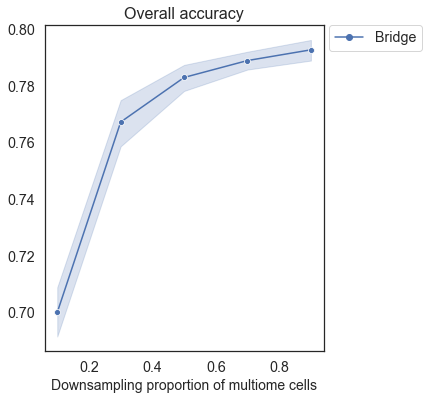

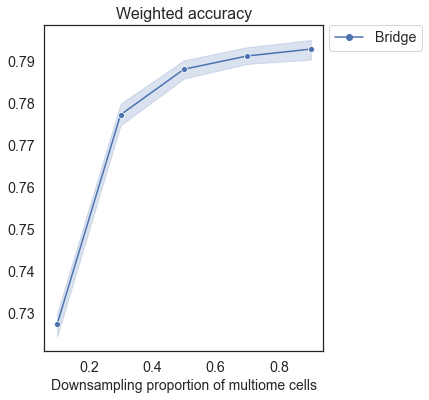

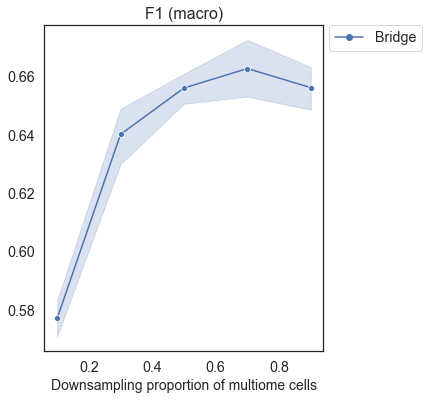

In [92]:
xp = 'per_multiome_downsample'
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df = df.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})
for m in dic.keys():
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y=m, hue='method', style='method', markers=True, data=df, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title(dic[m], fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_%s.png' % (xp,m), dpi=600, bbox_inches="tight")

In [93]:
xp = 'per_downsample'
df1 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df1 = df1.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'per_RNA_downsample'
df2 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df2 = df2.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'per_multiome_downsample'
df3 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df3 = df3.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

xp = 'per_ATAC_downsample'
df4 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/metrics_%s_2022-09-20.csv' % xp, index_col=0)
df4 = df4.replace({'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 'bridge': 'Bridge',
       'seurat3': 'Seurat v3', 'knn': 'KNN', 'random': 'Random', 'ensemble': 'Ensemble'})

In [94]:
df_m = pd.concat([df1,df2,df3,df4])
df_m.index = pd.Index(np.arange(df_m.shape[0]))
df_m = df_m.replace({'per_downsample': 'Downsample all cells', 'per_RNA_downsample': 'Downsample RNA cells',
                    'per_ATAC_downsample': 'Downsample ATAC cells', 'per_multiome_downsample': 'Downsample multiome cells'})

In [95]:
palette = {'Downsample all cells': '#4c72b0', 'Downsample RNA cells': '#3FE0D0',
           'Downsample ATAC cells': '#00a0FF', 'Downsample multiome cells': '#00B081'}

In [96]:
df_m.xp = df_m.xp.astype('category')
xps = ['Downsample all cells', 'Downsample ATAC cells', 'Downsample multiome cells', 'Downsample RNA cells']
df_m.xp = df_m.xp.cat.reorder_categories(xps)

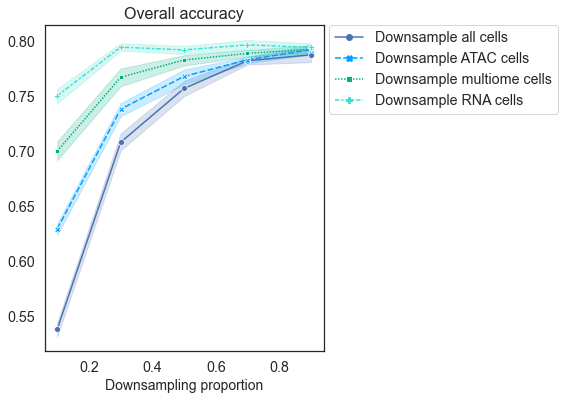

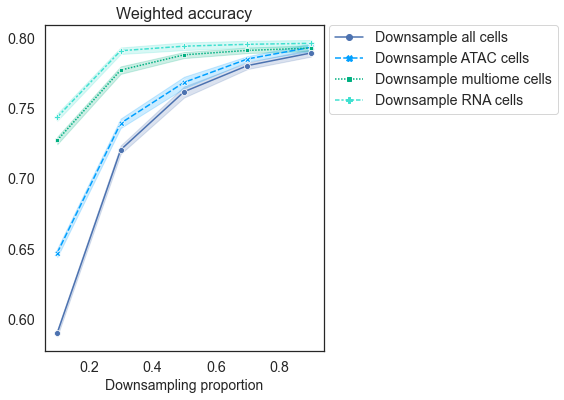

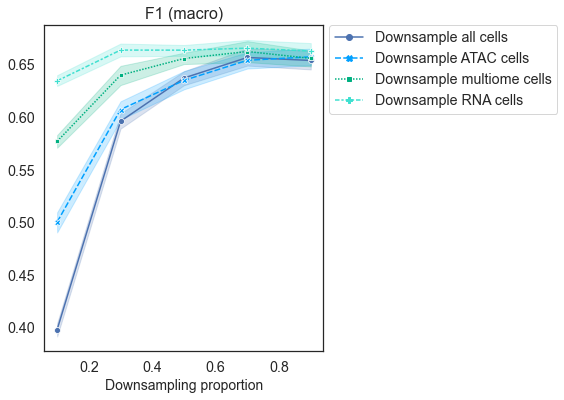

In [97]:
methods = ['Bridge integration', 'scJoint', 'scGCN', 'Seurat3','Conos (Pagoda2)', 'KNN', 'Random']
for method in ['Bridge']:
    for m in dic.keys():
        fig, ax = plt.subplots()
    #     sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method=='Bridge integration'], ax=ax, err_style="bars", errorbar=("se", 1.96))
        sns.lineplot(x='data', y=m, hue='xp', style='xp', markers=True, data=df_m[df_m.method==method], ax=ax, palette=palette)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        ax.set_ylabel('')
        ax.set_xlabel('Downsampling proportion', fontsize=14)
        ax.set_title(dic[m], fontsize=16)
        plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_downsample_%s_%s.png' % (method, m), dpi=600, bbox_inches="tight")

# Time & mem

In [95]:
import pandas as pd
import numpy as np

In [96]:
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_gpu_part2.csv', header=None, index_col=None)

In [196]:
del df[0]

In [197]:
df

1         2
0     00:00:16    1.21MB
1     00:00:40  329.27MB
2     00:00:10  206.56MB
3     00:00:19  328.98MB
4     00:00:11  204.50MB
...        ...       ...
1195  00:18:56    6.50GB
1196  00:19:29    6.48GB
1197  00:18:44    6.55GB
1198  00:06:44    7.05GB
1199  00:06:50    6.49GB

[1200 rows x 2 columns]

In [198]:
dic = {'num_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'num_RNA_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'num_multiome_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'per_mislabel': ['10', '30', '50', '70', '90'],
       'per_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_RNA_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_ATAC_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_multiome_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'rm_RNA_ct': ['2', '6', '10'],
       'rm_multiome_ct': ['2', '6', '10']}

dic = {'per_RNA_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_ATAC_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9']
       }

dic = {'num_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'num_RNA_cells': ['0.2', '0.6', '1', '3', '5', '10'],
       'per_mislabel': ['10', '30', '50', '70', '90'],
       'per_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_RNA_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'per_ATAC_downsample': ['0.1', '0.3', '0.5', '0.7', '0.9'],
       'rm_RNA_ct': ['2', '6', '10']}

In [187]:
col_xp = []
col_method = []
col_data = []
col_seed = []
for xp in dic.keys():
    if xp in ['num_multiome_cells', 'per_multiome_downsample', 'rm_multiome_ct']:
        methods = ['bridge']
    else:
        methods = ['conos', 'conos_pagoda', 'seurat3', 'bridge', 'scGCN_prep']
    for method in methods:
        for data in dic[xp]:
            for seed in range(20):
                col_xp.append(xp)
                col_method.append(method)
                col_data.append(data)
                col_seed.append(seed)

In [188]:
col_xp = []
col_method = []
col_data = []
col_seed = []
for xp in dic.keys():
    methods = ['scJoint']
    for method in methods:
        for data in dic[xp]:
            for seed in range(20):
                col_xp.append(xp)
                col_method.append(method)
                col_data.append(data)
                col_seed.append(seed)

In [199]:
col_xp = []
col_method = []
col_data = []
col_seed = []
for xp in dic.keys():
    if xp in ['per_RNA_downsample', 'per_ATAC_downsample']:
        methods = ['scGCN']
    else:
        methods = ['scGCN', 'scJoint']
    for method in methods:
        for data in dic[xp]:
            for seed in range(20):
                col_xp.append(xp)
                col_method.append(method)
                col_data.append(data)
                col_seed.append(seed)

In [200]:
len(col_xp)

1200

In [201]:
df['xp'] = col_xp
df['method'] = col_method
df['data'] = col_data
df['seed'] = col_seed

In [202]:
df

1         2         xp   method data  seed
0     00:00:16    1.21MB  num_cells    scGCN  0.2     0
1     00:00:40  329.27MB  num_cells    scGCN  0.2     1
2     00:00:10  206.56MB  num_cells    scGCN  0.2     2
3     00:00:19  328.98MB  num_cells    scGCN  0.2     3
4     00:00:11  204.50MB  num_cells    scGCN  0.2     4
...        ...       ...        ...      ...  ...   ...
1195  00:18:56    6.50GB  rm_RNA_ct  scJoint   10    15
1196  00:19:29    6.48GB  rm_RNA_ct  scJoint   10    16
1197  00:18:44    6.55GB  rm_RNA_ct  scJoint   10    17
1198  00:06:44    7.05GB  rm_RNA_ct  scJoint   10    18
1199  00:06:50    6.49GB  rm_RNA_ct  scJoint   10    19

[1200 rows x 6 columns]

In [176]:
df = df[~df.method.isin(['conos', 'conos_pagoda'])]

In [203]:
df.shape

(1200, 6)

In [204]:
df.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_gpu_part2_tmp.csv')

In [ ]:
# Concat dfs

In [211]:
df1 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_gpu_part_tmp.csv', index_col=0)
df2 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_gpu_part2_tmp.csv', index_col=0)

In [212]:
df_gpu = pd.concat([df1, df2])

In [229]:
tmp = []
for i in list(df_gpu['2']):
    if i.endswith('GB'):
        tmp.append(float(i[:-2]))
    elif i.endswith('MB'):
        tmp.append(float(i[:-2])/1000)
    else:
        print('unit not either MB or GB')
df_gpu['memory'] = tmp

In [237]:
tmp = []
for i in list(df_gpu['1']):
    h, m, s = i.split(':')
    tmp.append(float(h)*60 + float(m) + float(s)/60)
df_gpu['time'] = tmp

In [239]:
df_gpu.head()

1       2                  xp   method  data  seed  memory  \
0  00:20:35  7.23GB  per_RNA_downsample  scJoint   0.1     0    7.23   
1  00:06:27  7.02GB  per_RNA_downsample  scJoint   0.1     1    7.02   
2  00:06:24  7.00GB  per_RNA_downsample  scJoint   0.1     2    7.00   
3  00:06:30  7.02GB  per_RNA_downsample  scJoint   0.1     3    7.02   
4  00:06:27  6.30GB  per_RNA_downsample  scJoint   0.1     4    6.30   

        time  
0  20.583333  
1   6.450000  
2   6.400000  
3   6.500000  
4   6.450000

In [240]:
df1 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_r_conos_tmp.csv', index_col=0)
df2 = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp_r_all_tmp.csv', index_col=0)

In [243]:
df_r = pd.concat([df1, df2])

In [245]:
tmp = []
for i in list(df_r['2']):
    if i.endswith('GB'):
        tmp.append(float(i[:-2]))
    elif i.endswith('MB'):
        tmp.append(float(i[:-2])/1000)
    else:
        print('unit not either MB or GB')
df_r['memory'] = tmp

In [246]:
tmp = []
for i in list(df_r['1']):
    h, m, s = i.split(':')
    tmp.append(float(h)*60 + float(m) + float(s)/60)
df_r['time'] = tmp

In [247]:
df_r.head()

1       2         xp method  data  seed  memory      time
0  00:01:38  6.23GB  num_cells  conos   0.2     0    6.23  1.633333
1  00:01:42  5.65GB  num_cells  conos   0.2     1    5.65  1.700000
2  00:01:41  5.94GB  num_cells  conos   0.2     2    5.94  1.683333
3  00:01:40  6.03GB  num_cells  conos   0.2     3    6.03  1.666667
4  00:01:40  5.90GB  num_cells  conos   0.2     4    5.90  1.666667

In [248]:
df_all = pd.concat([df_r, df_gpu])

In [254]:
df_all.method.value_counts()

bridge          980
conos           700
conos_pagoda    700
seurat3         700
scGCN_prep      700
scJoint         700
scGCN           700
Name: method, dtype: int64

In [255]:
df_all = df_all.replace({'scGCN': 'scGCN (train)', 'conos': 'Conos (Seurat)', 'conos_pagoda': 'Conos (Pagoda2)', 
                         'bridge': 'Bridge integration', 'seurat3': 'Seurat3', 'scGCN_prep': 'scGCN (prep)'})

In [256]:
df_all.method.value_counts()

Bridge integration    980
Conos (Seurat)        700
Conos (Pagoda2)       700
Seurat3               700
scGCN (prep)          700
scJoint               700
scGCN (train)         700
Name: method, dtype: int64

In [264]:
del df_all['1'], df_all['2']

In [265]:
# Deal with scGCN

In [266]:
df_scGCN_prep = df_all[df_all.method == 'scGCN (prep)']
df_scGCN_train = df_all[df_all.method == 'scGCN (train)']

In [267]:
df_scGCN_prep

xp        method  data  seed  memory       time
480   num_cells  scGCN (prep)   0.2     0    5.46   2.200000
481   num_cells  scGCN (prep)   0.2     1    5.83   2.166667
482   num_cells  scGCN (prep)   0.2     2    6.51   2.116667
483   num_cells  scGCN (prep)   0.2     3    6.51   2.100000
484   num_cells  scGCN (prep)   0.2     4    6.51   2.116667
...         ...           ...   ...   ...     ...        ...
3715  rm_RNA_ct  scGCN (prep)  10.0    15    8.83  14.866667
3716  rm_RNA_ct  scGCN (prep)  10.0    16    8.86  15.350000
3717  rm_RNA_ct  scGCN (prep)  10.0    17    8.68  15.316667
3718  rm_RNA_ct  scGCN (prep)  10.0    18    8.65  15.183333
3719  rm_RNA_ct  scGCN (prep)  10.0    19    8.89  15.383333

[700 rows x 6 columns]

In [268]:
df_scGCN_train

xp         method  data  seed   memory       time
0     num_cells  scGCN (train)   0.2     0  0.00121   0.266667
1     num_cells  scGCN (train)   0.2     1  0.32927   0.666667
2     num_cells  scGCN (train)   0.2     2  0.20656   0.166667
3     num_cells  scGCN (train)   0.2     3  0.32898   0.316667
4     num_cells  scGCN (train)   0.2     4  0.20450   0.183333
...         ...            ...   ...   ...      ...        ...
1135  rm_RNA_ct  scGCN (train)  10.0    15  3.87000  19.600000
1136  rm_RNA_ct  scGCN (train)  10.0    16  3.89000  19.900000
1137  rm_RNA_ct  scGCN (train)  10.0    17  3.87000   7.450000
1138  rm_RNA_ct  scGCN (train)  10.0    18  3.90000   7.300000
1139  rm_RNA_ct  scGCN (train)  10.0    19  3.93000   7.200000

[700 rows x 6 columns]

In [313]:
df_scGCN_combined = df_scGCN_train.copy()
del df_scGCN_combined['time']
del df_scGCN_combined['memory']
df_scGCN_combined['memory'] = pd.DataFrame({'prep':df_scGCN_prep.memory.tolist(), 'train':df_scGCN_train.memory.tolist()}).max(1).tolist()
df_scGCN_combined['time'] = df_scGCN_prep.time.values + df_scGCN_train.time.values
df_scGCN_combined = df_scGCN_combined.replace({'scGCN (train)': 'scGCN'})

In [314]:
df_scGCN_combined

xp method  data  seed  memory       time
0     num_cells  scGCN   0.2     0    5.46   2.466667
1     num_cells  scGCN   0.2     1    5.83   2.833333
2     num_cells  scGCN   0.2     2    6.51   2.283333
3     num_cells  scGCN   0.2     3    6.51   2.416667
4     num_cells  scGCN   0.2     4    6.51   2.300000
...         ...    ...   ...   ...     ...        ...
1135  rm_RNA_ct  scGCN  10.0    15    8.83  34.466667
1136  rm_RNA_ct  scGCN  10.0    16    8.86  35.250000
1137  rm_RNA_ct  scGCN  10.0    17    8.68  22.766667
1138  rm_RNA_ct  scGCN  10.0    18    8.65  22.483333
1139  rm_RNA_ct  scGCN  10.0    19    8.89  22.583333

[700 rows x 6 columns]

In [315]:
df = pd.concat([df_all, df_scGCN_combined])

In [316]:
df

xp          method  data  seed  memory       time
0     num_cells  Conos (Seurat)   0.2     0    6.23   1.633333
1     num_cells  Conos (Seurat)   0.2     1    5.65   1.700000
2     num_cells  Conos (Seurat)   0.2     2    5.94   1.683333
3     num_cells  Conos (Seurat)   0.2     3    6.03   1.666667
4     num_cells  Conos (Seurat)   0.2     4    5.90   1.666667
...         ...             ...   ...   ...     ...        ...
1135  rm_RNA_ct           scGCN  10.0    15    8.83  34.466667
1136  rm_RNA_ct           scGCN  10.0    16    8.86  35.250000
1137  rm_RNA_ct           scGCN  10.0    17    8.68  22.766667
1138  rm_RNA_ct           scGCN  10.0    18    8.65  22.483333
1139  rm_RNA_ct           scGCN  10.0    19    8.89  22.583333

[5880 rows x 6 columns]

In [320]:
df.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp.csv')

In [20]:
df = pd.read_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/time_mem/BMMC_xp.csv', index_col=0)

In [21]:
title_dic = {'rm_RNA_ct': 'Number of removed cell types in RNA',
             'rm_multiome_ct': 'Number of removed cell types in multiome',
             'num_cells': 'Number of cells (k)',
             'num_RNA_cells': 'Number of RNA cells (k)',
             'num_multiome_cells': 'Number of multiome cells (k)',
             'per_mislabel':'Mislabel proportion',
             'per_downsample': 'Downsampling proportion',
             'per_RNA_downsample': 'Downsampling proportion of RNA cells',
             'per_ATAC_downsample': 'Downsampling proportion of ATAC cells',
             'per_multiome_downsample': 'Downsampling proportion of multiome cells'}
title_dic = {'num_cells': 'Number of cells (k)',
             'num_RNA_cells': 'Number of RNA cells (k)',
             'num_multiome_cells': 'Number of multiome cells (k)'}

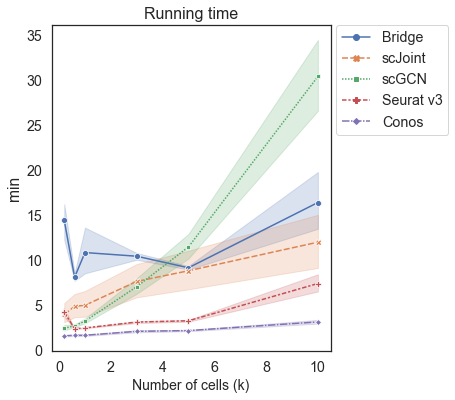

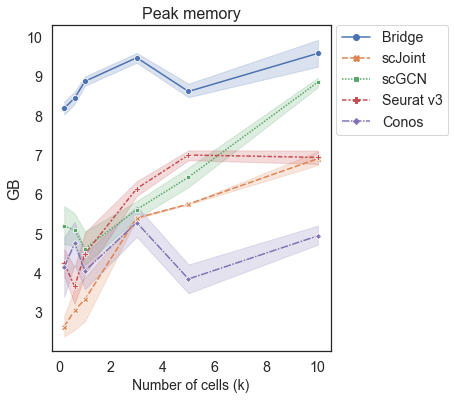

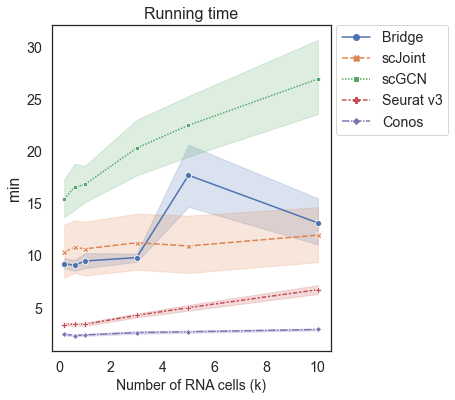

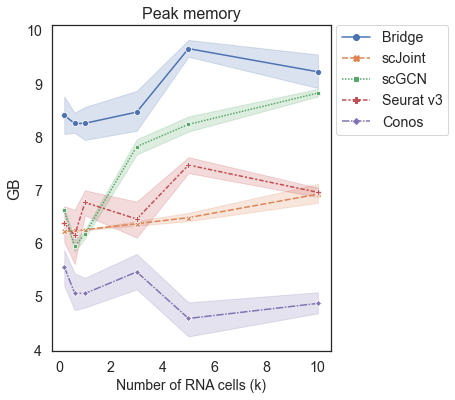

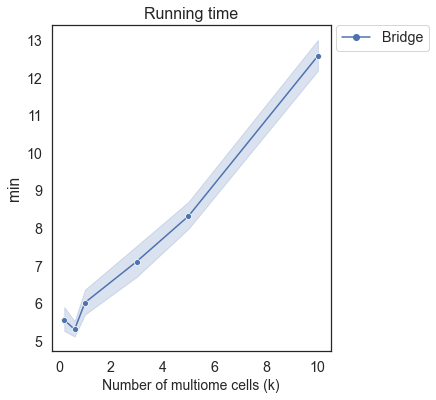

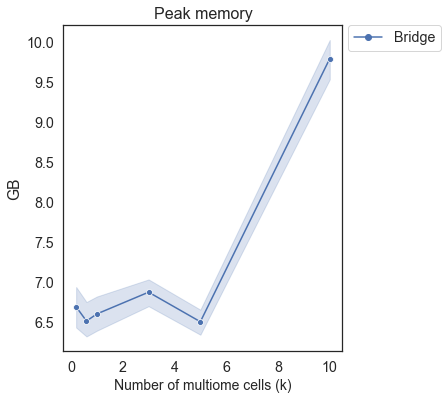

In [23]:
for xp in title_dic.keys():
    df_sub = df[df.xp == xp]
    df_sub = df_sub[~df_sub.method.isin(['Conos (Seurat)', 'scGCN (prep)', 'scGCN (train)'])]
    df_sub = df_sub.replace({'Conos (Pagoda2)': 'Conos', 'Bridge integration': 'Bridge', 'Seurat3': 'Seurat v3'})
    if xp != 'num_multiome_cells':
        df_sub.method = df_sub.method.astype('category')
        methods = ['Bridge', 'scJoint', 'scGCN', 'Seurat v3','Conos']
        df_sub.method = df_sub.method.cat.reorder_categories(methods)
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y='time', hue='method', style='method', markers=True, data=df_sub, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('min')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title('Running time', fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_time.png' % (xp), dpi=600, bbox_inches="tight")
    fig, ax = plt.subplots()
    sns.lineplot(x='data', y='memory', hue='method', style='method', markers=True, data=df_sub, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel('GB')
    ax.set_xlabel(title_dic[xp], fontsize=14)
    ax.set_title('Peak memory', fontsize=16)
    plt.savefig('/gpfs/gibbs/pi/zhao/yw599/Multiome/metrics/BMMC_xp_%s_mem.png' % (xp), dpi=600, bbox_inches="tight")